# Curation and creation of data for LLM finetuning

## 0. Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import json

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## 1. Annotation train-test split

In [3]:
from src.annotation.parse_annotations_helpers import parse_labelstudio_json
round1_labelstudio_path = "../data/processed/annotations/label-studio/label-studio-annotations-2025-07-24-15-40-21147c14.json"

# === Step 0: Clean and group ===
df = parse_labelstudio_json(round1_labelstudio_path)
df = df[df["SDoH"].notnull()]
df["SDoH"] = df["SDoH"].str.strip()
df["Polarity"] = df["Polarity"].fillna("").str.strip()

# === Define canonical label mapping (annotation → model expected) ===
label_name_map = {
    "Food": "FoodAccess",
    "English": "EnglishProficiency",
    "No SDoH": "NoSDoH",  # just to catch if it sneaks in
}

def make_label(sdoh, polarity):
    sdoh = sdoh.strip()
    polarity = polarity.strip()
    
    # Normalize label name
    sdoh_key = sdoh.lower().replace(" ", "")
    if sdoh_key == "nosdoh":
        return "NoSDoH"
    
    # Map to canonical names
    sdoh = label_name_map.get(sdoh, sdoh)

    return f"{sdoh}-{polarity}"

df["label_pair"] = df.apply(lambda row: make_label(row["SDoH"], row["Polarity"]), axis=1)

In [4]:
from sklearn.model_selection import train_test_split

# Group per sentence
sentence_labels = (
    df.groupby("Sentence")["label_pair"]
    .apply(lambda x: sorted(set(x)))
    .reset_index()
)
sentence_labels["label_string"] = sentence_labels["label_pair"].apply(lambda x: "|".join(x))

# === Step 1: Separate singleton label groups ===
label_counts = sentence_labels["label_string"].value_counts()
singleton_labels = label_counts[label_counts == 1].index

non_singletons = sentence_labels[sentence_labels["label_string"].isin(label_counts[label_counts > 1].index)]
singletons = sentence_labels[sentence_labels["label_string"].isin(singleton_labels)]

# === Step 2: First split: train/test (70/30) for non-singletons ===
train_ns, test_ns = train_test_split(
    non_singletons,
    test_size=0.3,
    stratify=non_singletons["label_string"],
    random_state=42
)

# === Step 3: Second split: train/val (80/20 of training set) for non-singletons ===
train_ns, val_ns = train_test_split(
    train_ns,
    test_size=0.2,
    random_state=42,
    shuffle=True  # still shuffles
)

# === Step 4: Manual split for singletons (70/30 → then 80/20 again) ===
np.random.seed(42)
singleton_shuffled = singletons.sample(frac=1.0, random_state=42)

n_singleton_total = len(singleton_shuffled)
n_test = int(n_singleton_total * 0.3)
n_remaining = n_singleton_total - n_test
n_val = int(n_remaining * 0.2)
n_train = n_remaining - n_val

test_singletons = singleton_shuffled.iloc[:n_test]
val_singletons = singleton_shuffled.iloc[n_test:n_test + n_val]
train_singletons = singleton_shuffled.iloc[n_test + n_val:]

# === Step 5: Combine splits ===
train_set = pd.concat([train_ns, train_singletons], ignore_index=True)
val_set   = pd.concat([val_ns, val_singletons], ignore_index=True)
test_set  = pd.concat([test_ns, test_singletons], ignore_index=True)

# === Step 6: Format completions ===
for df_ in [train_set, val_set, test_set]:
    df_["completion"] = df_["label_pair"].apply(lambda x: "<LIST>" + ", ".join(x) + "</LIST>")

# === Step 7: Save splits ===
train_set.to_csv("../data/processed/train-test/train_set.csv", index=False)
val_set.to_csv("../data/processed/train-test/val_set.csv", index=False)
test_set.to_csv("../data/processed/train-test/test_set.csv", index=False)

print(f"Train size: {len(train_set)}, Val size: {len(val_set)}, Test size: {len(test_set)}")
print(f"Included {len(singletons)} singleton label combinations split in two steps (80/20 then 80/20)")

Train size: 520, Val size: 130, Test size: 278
Included 16 singleton label combinations split in two steps (80/20 then 80/20)


### Check weights (ratio of negative to positive class)

In [4]:
from scripts.roberta.dataset import is_sdoh_label

train_df = pd.read_csv("../data/processed/train-test/train_set.csv")
train_df["binary_label"] = train_df["completion"].apply(is_sdoh_label)

# Compute class weights
num_pos = train_df["binary_label"].sum()
num_neg = len(train_df) - num_pos
pos_weight_val = num_neg / num_pos

print(f"Positive class weight: {pos_weight_val:.2f} (ratio of negative to positive examples)")

Positive class weight: 1.18 (ratio of negative to positive examples)


### Check number of tokens in training data

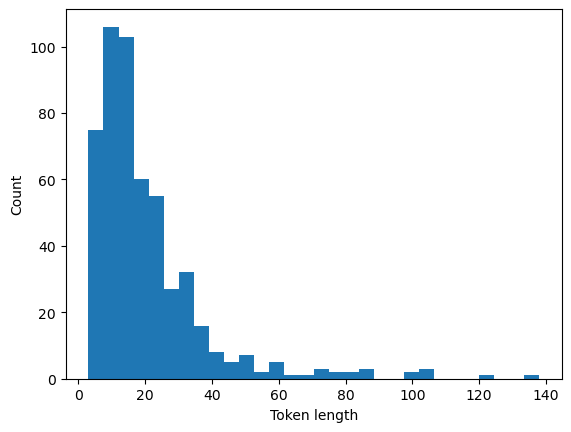

In [6]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

lengths = [len(tokenizer.tokenize(s)) for s in train_df["Sentence"]]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=30)
plt.xlabel("Token length")
plt.ylabel("Count")
plt.savefig("../results/figures/appendix/train_token_length_distribution.png", dpi=300)
plt.show()

## EDA

In [16]:
import ast

def compute_sdoh_proportions_with_counts(df, dataset_name):
    df = df.copy()
    df["label_pair"] = df["label_pair"].apply(ast.literal_eval)
    df["flattened"] = df["label_pair"].apply(set)

    df["has_NoSDoH"] = df["flattened"].apply(lambda s: s == {"NoSDoH"})

    sdoh_categories = [
        "Finances", "FoodAccess", "Employment", "Loneliness",
        "Housing", "DigitalInclusion", "EnglishProficiency"
    ]

    for cat in sdoh_categories:
        df[cat] = df["flattened"].apply(lambda labels: any(label.startswith(cat) for label in labels))

    total = len(df)
    row = {"Dataset": dataset_name}
    row["% NoSDoH"] = f"{df['has_NoSDoH'].mean() * 100:.1f}% ({df['has_NoSDoH'].sum()})"
    for cat in sdoh_categories:
        count = df[cat].sum()
        perc = (count / total) * 100
        row[f"% {cat}"] = f"{perc:.1f}% ({count})"
    return pd.DataFrame([row])

# === Load CSVs ===
train_df = pd.read_csv("../data/processed/train-test/train_set.csv")
val_df = pd.read_csv("../data/processed/train-test/val_set.csv")
test_df = pd.read_csv("../data/processed/train-test/test_set.csv")

# === Compute table ===
train_stats = compute_sdoh_proportions_with_counts(train_df, "Train")
val_stats = compute_sdoh_proportions_with_counts(val_df, "Validation")
test_stats = compute_sdoh_proportions_with_counts(test_df, "Test")
combined_stats = compute_sdoh_proportions_with_counts(
    pd.concat([train_df, val_df, test_df], ignore_index=True), "Combined"
)

proportions_table = pd.concat([train_stats, val_stats, test_stats, combined_stats], ignore_index=True)
print(proportions_table.to_markdown(index=False))

| Dataset    | % NoSDoH    | % Finances   | % FoodAccess   | % Employment   | % Loneliness   | % Housing   | % DigitalInclusion   | % EnglishProficiency   |
|:-----------|:------------|:-------------|:---------------|:---------------|:---------------|:------------|:---------------------|:-----------------------|
| Train      | 54.0% (281) | 7.5% (39)    | 9.4% (49)      | 5.0% (26)      | 17.7% (92)     | 11.9% (62)  | 4.6% (24)            | 4.8% (25)              |
| Validation | 53.8% (70)  | 9.2% (12)    | 10.0% (13)     | 5.4% (7)       | 20.8% (27)     | 11.5% (15)  | 2.3% (3)             | 1.5% (2)               |
| Test       | 54.0% (150) | 6.8% (19)    | 9.0% (25)      | 5.0% (14)      | 18.0% (50)     | 12.2% (34)  | 4.0% (11)            | 4.7% (13)              |
| Combined   | 54.0% (501) | 7.5% (70)    | 9.4% (87)      | 5.1% (47)      | 18.2% (169)    | 12.0% (111) | 4.1% (38)            | 4.3% (40)              |
